In [1]:
import os
import warnings
import sys

import dvc.api
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet, LogisticRegression
from sklearn.preprocessing import LabelEncoder
from fast_ml.model_development import train_valid_test_split
from sklearn.tree import DecisionTreeClassifier
from urllib.parse import urlparse
import mlflow
import mlflow.sklearn
import logging

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from ml import Ml
from preprocess import Preprocess

In [4]:
ml = Ml()
preprocess = Preprocess()

In [5]:
df = pd.read_csv('../data/AdSmartABdata.csv')
df

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0
...,...,...,...,...,...,...,...,...,...
8072,ffea24ec-cec1-43fb-b1d1-8f93828c2be2,exposed,2020-07-05,7,Generic Smartphone,6,Chrome Mobile,0,0
8073,ffea3210-2c3e-426f-a77d-0aa72e73b20f,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0
8074,ffeaa0f1-1d72-4ba9-afb4-314b3b00a7c7,control,2020-07-04,9,Generic Smartphone,6,Chrome Mobile,0,0
8075,ffeeed62-3f7c-4a6e-8ba7-95d303d40969,exposed,2020-07-05,15,Samsung SM-A515F,6,Samsung Internet,0,0


In [ ]:
# Get URL from DVC
# path = 'data/AdSmartABdata.csv'
# repo = 'https://github.com/jedisam/abtest-mlops'
# version = '6db449393c9626c4fbca44946dfa103660685a27'

In [ ]:
# Load data from dvc using the dvc.api.Dataset class
# data_url = dvc.api.get_url(
#     path=path,
#     repo=repo,
#     rev=version
# )
# data_url

In [ ]:
# Read CSV file from remote repository
# data = pd.read_csv(data_url, sep=',')
# data

In [6]:
# change the date column to datetime
# from preprocess import Preprocess
data = preprocess.convert_to_datetime(df, 'date')
data

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0
...,...,...,...,...,...,...,...,...,...
8072,ffea24ec-cec1-43fb-b1d1-8f93828c2be2,exposed,2020-07-05,7,Generic Smartphone,6,Chrome Mobile,0,0
8073,ffea3210-2c3e-426f-a77d-0aa72e73b20f,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0
8074,ffeaa0f1-1d72-4ba9-afb4-314b3b00a7c7,control,2020-07-04,9,Generic Smartphone,6,Chrome Mobile,0,0
8075,ffeeed62-3f7c-4a6e-8ba7-95d303d40969,exposed,2020-07-05,15,Samsung SM-A515F,6,Samsung Internet,0,0


# Exploring the categorical columns

In [7]:
numerical_column = preprocess.get_numerical_columns(df)
categorical_column = preprocess.get_categorical_columns(df)

In [8]:
# drop auction_id from categorical_column
categorical_column.remove('auction_id')

In [9]:
# Get column names have less than 10 more than 2 unique values
to_one_hot_encoding = [col for col in categorical_column if df[col].nunique() <= 10 and df[col].nunique() > 2]

# Get Categorical Column names thoose are not in "to_one_hot_encoding"
to_label_encoding = [col for col in categorical_column if not col in to_one_hot_encoding]

In [11]:
# Label encoding
label_encoded_columns = preprocess.label_encode(df, to_label_encoding)

In [14]:
# Copy our DataFrame to X variable
X = df.copy()

# Droping Categorical Columns,
# "inplace" means replace our data with new one
# Don't forget to "axis=1"
X.drop(categorical_column, axis=1, inplace=True)

# Merge DataFrames
X = pd.concat([X, label_encoded_columns], axis=1)


In [15]:
# Select only rows with responses
X = X.query('yes == 1 | no == 1')

In [16]:
# Drop auction_id column
X.drop(["auction_id"], axis=1, inplace=True)

In [17]:
X['target'] = [1] * X.shape[0]
X.loc[X['no'] == 1, 'target'] = 0
y = X['target']
X.drop(["target"], axis=1, inplace=True)
X.drop(['yes', 'no'], axis=1, inplace=True)

In [18]:
# Get the day of the week from the date column as a new column
X['day'] = X['date'].dt.dayofweek
X.drop(["date"], axis=1, inplace=True)

# Logistic Regression

In [28]:
logistic_regression_model = LogisticRegression(random_state=0)
logistic_regression_result = ml.cross_validation(logistic_regression_model, X, y, 5)
logistic_regression_result

{'Training Accuracy scores': array([0.55533199, 0.5694165 , 0.54124748, 0.55577889, 0.55879397]),
 'Mean Training Accuracy': 55.61137680353478,
 'Training Precision scores': array([0.55333333, 0.5721393 , 0.5046729 , 0.54255319, 0.56291391]),
 'Mean Training Precision': 0.5471225265572623,
 'Training Recall scores': array([0.18122271, 0.25164114, 0.11816193, 0.22270742, 0.18558952]),
 'Mean Training Recall': 0.19186454282247042,
 'Training F1 scores': array([0.27302632, 0.34954407, 0.19148936, 0.31578947, 0.27914614]),
 'Mean Training F1 Score': 0.28179907306784935,
 'Validation Accuracy scores': array([0.5502008 , 0.47791165, 0.5502008 , 0.53225806, 0.55645161]),
 'Mean Validation Accuracy': 53.34045860862806,
 'Validation Precision scores': array([0.52380952, 0.33333333, 0.55172414, 0.48      , 0.55      ]),
 'Mean Validation Precision': 0.48777339901477834,
 'Validation Recall scores': array([0.19298246, 0.13043478, 0.13913043, 0.21052632, 0.19298246]),
 'Mean Validation Recall': 0.

### Plot Accuracy Result

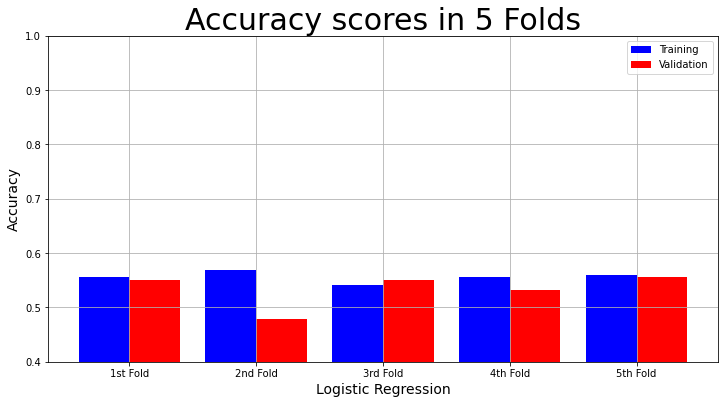

In [23]:
# Plot Accuracy Result
model_name = "Logistic Regression"
ml.plot_result(model_name, "Accuracy", "Accuracy scores in 5 Folds", logistic_regression_result["Training Accuracy scores"], logistic_regression_result["Validation Accuracy scores"])

### Plot Precision Result

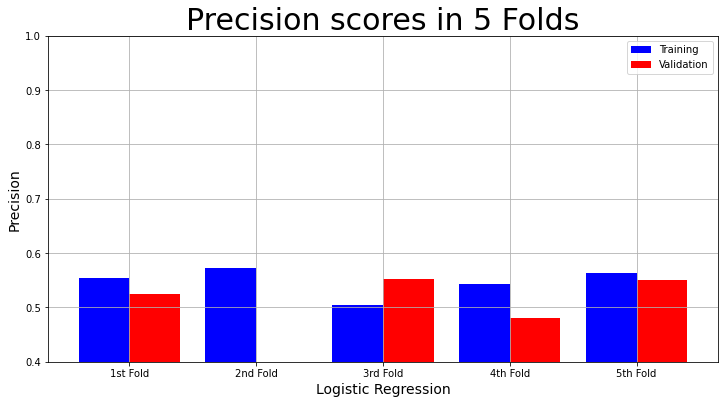

In [24]:
# Plot Precision Result
ml.plot_result(model_name, "Precision", "Precision scores in 5 Folds", logistic_regression_result["Training Precision scores"], logistic_regression_result["Validation Precision scores"])

### Recall Results plot

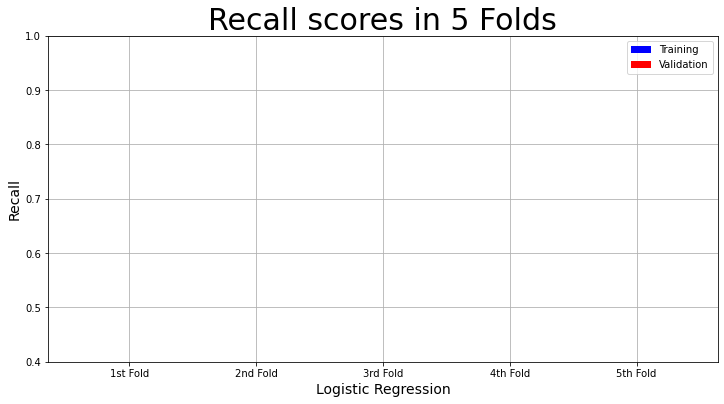

In [25]:
# Plot Recall Result
ml.plot_result(model_name, "Recall", "Recall scores in 5 Folds", logistic_regression_result["Training Recall scores"], logistic_regression_result["Validation Recall scores"])


### f1 score result

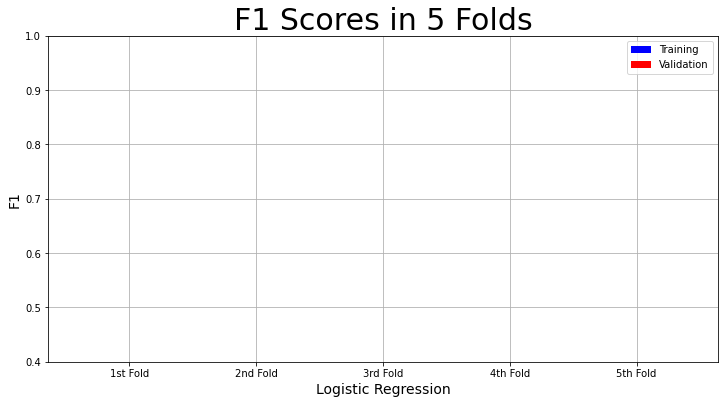

In [27]:
# Plot F1-Score Result
ml.plot_result(model_name, "F1", "F1 Scores in 5 Folds", logistic_regression_result["Training F1 scores"], logistic_regression_result["Validation F1 scores"])